# Variational QEP with derivative information in 2d

## Introduction
In this example, we show how to train an approximate/variational QEP model in QPyTorch of a 2-dimensional function given function values and derivative observations. We consider modeling the Franke functions where the values and derivatives are contaminated with independent $\mathcal{N}(0, 0.05^2)$ distributed noise.

In [1]:
import torch
import qpytorch
import math
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Franke function
The following is a vectorized implementation of the 2-dimensional Franke function ((https://www.sfu.ca/~ssurjano/franke2d.html)). To make it more challenging than [GPyTorch implementation](https://docs.gpytorch.ai/en/stable/examples/08_Advanced_Usage/Simple_GP_Regression_Derivative_Information_2d.html), we include the second order derivatives.

In [2]:
# generate data
def franke(X, Y):
    term1 = .75*torch.exp(-((9*X - 2).pow(2) + (9*Y - 2).pow(2))/4)
    term2 = .75*torch.exp(-((9*X + 1).pow(2))/49 - (9*Y + 1)/10)
    term3 = .5*torch.exp(-((9*X - 7).pow(2) + (9*Y - 3).pow(2))/4)
    term4 = .2*torch.exp(-(9*X - 4).pow(2) - (9*Y - 7).pow(2))

    f = term1 + term2 + term3 - term4
    dfx = -2*(9*X - 2)*9/4 * term1 - 2*(9*X + 1)*9/49 * term2 + \
          -2*(9*X - 7)*9/4 * term3 + 2*(9*X - 4)*9 * term4
    dfy = -2*(9*Y - 2)*9/4 * term1 - 9/10 * term2 + \
          -2*(9*Y - 3)*9/4 * term3 + 2*(9*Y - 7)*9 * term4
    d2fx = ((2*(9*X - 2)*9/4)**2 - 2*9*9/4) * term1 + ((2*(9*X + 1)*9/49)**2 - 2*9*9/49) * term2 + \
          +((2*(9*X - 7)*9/4)**2 - 2*9*9/4) * term3 - ((2*(9*X - 4)*9)**2 - 2*9*9) * term4
    d2fy = ((2*(9*Y - 2)*9/4)**2 - 2*9*9/4) * term1 + (9/10)**2 * term2 + \
          +((2*(9*Y - 3)*9/4)**2 - 2*9*9/4) * term3 - ((2*(9*Y - 7)*9)**2 - 2*9*9) * term4

    return f, dfx, dfy, d2fx, d2fy

## Setting up the training data
We use a grid with 225 points in $[0,1] \times [0,1]$ with 15 uniformly distributed points per dimension.

In [3]:
xv, yv = torch.meshgrid(torch.linspace(0, 1, 15), torch.linspace(0, 1, 15), indexing="ij")
train_x = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1
)

f, dfx, dfy, d2fx, d2fy = franke(train_x[:, 0], train_x[:, 1])
train_y = torch.stack([f, dfx, dfy, d2fx, d2fy], -1).squeeze(1)

train_y += 0.05 * torch.randn(train_y.size()) # Add noise to both values and gradients
lb, ub = 0, 1.0

## Setting up the model
A QEP prior on the function values implies a multi-output QEP prior on the function values and the partial derivatives, see 9.4 in http://www.gaussianprocess.org/gpml/chapters/RW9.pdf for more details. This allows using a `MultitaskMultivariateQExponential` and `MultitaskQExponentialLikelihood` to train an **exact** QEP model from both function values and gradients. 

However, if we want to use **variational** QEP, the standard `VariationalStrategy` does not take multitask variational distribution. To overcome this issue, QPyTorch extends `VariationalStrategy` to `MultitaskVariationalStrategy` so that it works with `MultitaskMultivariateQExponential`.
The resulting Matern52 kernel that models the covariance between the values and partial derivatives has been implemented in `Matern52KernelGradGrad` to include upto second order derivatives and the extension of a linear mean is implemented in `LinearMeanGradGrad`.

In [4]:
POWER = 1.0
class QEPModelWithDerivatives(qpytorch.models.ApproximateQEP):
    def __init__(self, input_dims, output_dims, num_inducing=128, likelihood=None):
        self.power = torch.tensor(POWER)
        inducing_points = lb + torch.rand(output_dims,num_inducing, input_dims) * (ub-lb)
        # inducing_points = train_x[torch.randperm(train_x.size(0))[:num_inducing]]
        batch_shape = torch.Size([output_dims])
        variational_distribution = qpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape,
            power=self.power
        )
        variational_strategy = qpytorch.variational.MultitaskVariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
            # jitter_val = 1.0e-4
        )
        
        super().__init__(variational_strategy)
        self.mean_module = qpytorch.means.LinearMeanGradGrad(input_dims)
        self.base_kernel = qpytorch.kernels.Matern52KernelGradGrad(ard_num_dims=input_dims, eps=1e-4, interleaved=False)
        self.covar_module = qpytorch.kernels.ScaleKernel(self.base_kernel)
        self.covar_module.base_kernel.register_constraint("raw_lengthscale", qpytorch.constraints.Interval(1e-2, 2))
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x) # ... x N x (D+1)
        covar_x = self.covar_module(x) # ... x N(D+1) x N(D+1)
        return qpytorch.distributions.MultitaskMultivariateQExponential(mean_x, covar_x, power=POWER, interleaved=False)

likelihood = qpytorch.likelihoods.MultitaskQExponentialLikelihood(num_tasks=train_y.size(-1), power=torch.tensor(POWER), 
                                                                  noise_constraint=qpytorch.constraints.Interval(1e-2,2))  # Value + Derivative
model = QEPModelWithDerivatives(train_x.size(-1), train_y.size(-1), likelihood=likelihood)

The model training is similar to training a standard variational QEP regression model.

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes QExponentialLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).sum()
    loss.backward()
    print("Iter %d/%d - Loss: %.3f   lengthscales: %.3f, %.3f   noise: %.3f" % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.squeeze()[0],
        model.covar_module.base_kernel.lengthscale.squeeze()[1],
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 92.150   lengthscales: 1.005, 1.005   noise: 1.005
Iter 2/50 - Loss: 89.432   lengthscales: 1.030, 1.030   noise: 1.030
Iter 3/50 - Loss: 86.067   lengthscales: 1.055, 1.055   noise: 1.055
Iter 4/50 - Loss: 83.225   lengthscales: 1.079, 1.079   noise: 1.079
Iter 5/50 - Loss: 80.565   lengthscales: 1.103, 1.102   noise: 1.103
Iter 6/50 - Loss: 78.135   lengthscales: 1.126, 1.125   noise: 1.126
Iter 7/50 - Loss: 75.887   lengthscales: 1.149, 1.147   noise: 1.149
Iter 8/50 - Loss: 73.703   lengthscales: 1.170, 1.167   noise: 1.171
Iter 9/50 - Loss: 71.835   lengthscales: 1.191, 1.187   noise: 1.193
Iter 10/50 - Loss: 69.881   lengthscales: 1.211, 1.204   noise: 1.213
Iter 11/50 - Loss: 68.241   lengthscales: 1.230, 1.220   noise: 1.233
Iter 12/50 - Loss: 66.479   lengthscales: 1.247, 1.235   noise: 1.252
Iter 13/50 - Loss: 64.905   lengthscales: 1.264, 1.247   noise: 1.269
Iter 14/50 - Loss: 63.350   lengthscales: 1.279, 1.258   noise: 1.286
Iter 15/50 - Loss: 61.875   l

Model predictions are also similar to QEP regression with only function values, but we need more CG iterations to get accurate estimates of the predictive variance

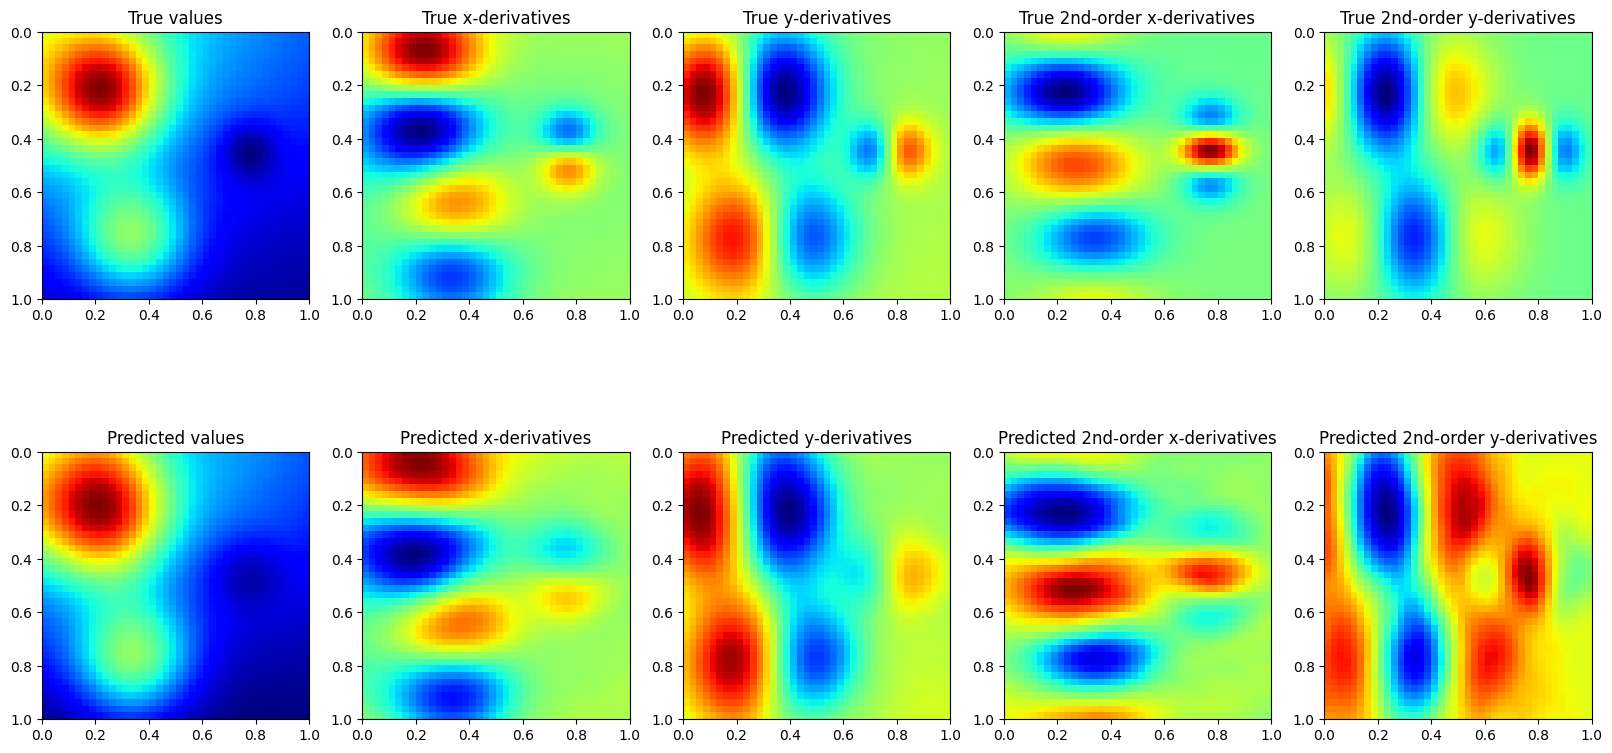

In [6]:
# Set into eval mode
model.eval()

# Initialize plots
fig, ax = plt.subplots(2, train_y.size(-1), figsize=(20, 10))

# Test points
n1, n2 = 40, 40
xv, yv = torch.meshgrid(torch.linspace(0, 1, n1), torch.linspace(0, 1, n2), indexing="ij")
f, dfx, dfy, d2fx, d2fy = franke(xv, yv)

# Make predictions
with torch.no_grad(), qpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    test_x = torch.stack([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1).squeeze(1)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    if mean.ndim == 3: mean = mean.mean(0)

extent = (xv.min(), xv.max(), yv.max(), yv.min())
ax[0, 0].imshow(f, extent=extent, cmap=cm.jet)
ax[0, 0].set_title('True values')
ax[0, 1].imshow(dfx, extent=extent, cmap=cm.jet)
ax[0, 1].set_title('True x-derivatives')
ax[0, 2].imshow(dfy, extent=extent, cmap=cm.jet)
ax[0, 2].set_title('True y-derivatives')
ax[0, 3].imshow(d2fx, extent=extent, cmap=cm.jet)
ax[0, 3].set_title('True 2nd-order x-derivatives')
ax[0, 4].imshow(d2fy, extent=extent, cmap=cm.jet)
ax[0, 4].set_title('True 2nd-order y-derivatives')

ax[1, 0].imshow(mean[:, 0].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 0].set_title('Predicted values')
ax[1, 1].imshow(mean[:, 1].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 1].set_title('Predicted x-derivatives')
ax[1, 2].imshow(mean[:, 2].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 2].set_title('Predicted y-derivatives')
ax[1, 3].imshow(mean[:, 3].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 3].set_title('Predicted 2nd-order x-derivatives')
ax[1, 4].imshow(mean[:, 4].detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1, 4].set_title('Predicted 2nd-order y-derivatives')

None